# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [4]:
random.uniform(10, 600)

548.9946882151672

In [12]:
import numpy as np
np.random.normal(10, 2)

9.057518035828513

In [29]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  # time_on_site = random.uniform(10, 600)
  time_on_site = np.random.normal(9.4*60, 3*60)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  # time_on_site = random.uniform(5, 300)
  time_on_site = np.random.normal(7.5*60, 2.5*60)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
users[:10]

[User(purchased=False, time_on_site=209.27321087194935, mobile=False),
 User(purchased=False, time_on_site=320.635670345549, mobile=True),
 User(purchased=True, time_on_site=656.7701214019546, mobile=True),
 User(purchased=True, time_on_site=666.0821871361638, mobile=True),
 User(purchased=True, time_on_site=482.0722908706248, mobile=True),
 User(purchased=False, time_on_site=531.3259087586263, mobile=True),
 User(purchased=False, time_on_site=361.7156643045132, mobile=True),
 User(purchased=False, time_on_site=794.5265878110738, mobile=True),
 User(purchased=True, time_on_site=320.20659536572896, mobile=True),
 User(purchased=False, time_on_site=630.7545324569822, mobile=False)]

In [30]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,209.273211,False
1,False,320.635670,True
2,True,656.770121,True
3,True,666.082187,True
4,True,482.072291,True


In [31]:
user_data['time_on_site_min'] = user_data['time_on_site'] / 60
user_data.head()

,purchased,time_on_site,mobile,time_on_site_min
0,False,209.273211,False,3.487887
1,False,320.635670,True,5.343928
2,True,656.770121,True,10.946169
3,True,666.082187,True,11.101370
4,True,482.072291,True,8.034538


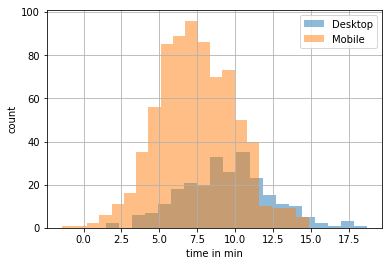

In [32]:
import matplotlib.pyplot as plt
user_data.groupby('mobile').time_on_site_min.hist(bins=20, alpha=0.5);
plt.xlabel('time in min');
plt.ylabel('count');
plt.legend(['Desktop', 'Mobile']);


In [33]:
user_data[user_data.time_on_site < 0.0]

,purchased,time_on_site,mobile,time_on_site_min
629,False,-83.949742,True,-1.399162


In [34]:
user_data.loc[user_data['time_on_site'] < 0.0, 'time_on_site'] = 0.0
user_data[user_data.time_on_site < 0.0]

,purchased,time_on_site,mobile,time_on_site_min


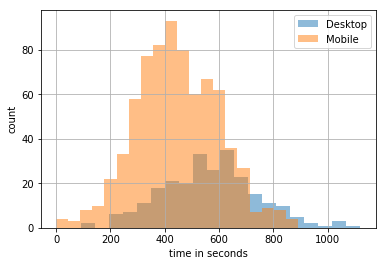

In [38]:
user_data.groupby('mobile').time_on_site.hist(bins=20, alpha=0.5);
plt.xlabel('time in seconds');
plt.ylabel('count');
plt.legend(['Desktop', 'Mobile']);

In [39]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,0.0,4.47155546918691,33.389765083758846,42.704910637938724,71.09969284794431,84.27181713763008,85.91170694845738,89.42311663641743,90.34912959557431,101.54157248920308,107.4215638362652,112.67502010319072,114.98401764219341,116.2831860732058,124.8115490370227,125.36220457880609,128.63930985697834,136.78517954156416,146.65956455141384,149.3198149843248,151.35634211283406,155.6626878616903,158.52605733613188,163.6156799946283,165.63560795658066,174.75306136894193,174.96246563936205,185.35143667715806,185.35656665704545,188.1416089505284,190.3911218345682,191.68174781957157,193.084741568614,194.0768575683753,195.57833204999295,196.20644006623553,200.26679237866568,201.12989050385463,201.19402874041742,201.71136106737288,...,795.6965778540437,798.3530318559756,801.2213530856266,802.6826136574721,802.7478621827332,805.9369489477754,807.6078690015823,808.320347181741,808.3506135725227,813.4079198712825,814.0135985241711,822.7861571622882,827.4989813683333,829.808456784787,830.0947181066522,832.3905594606937,838.0181169369719,838.2189925001937,839.1137631856873,841.8282941801415,850.8629553446258,854.9024149399438,856.4302832915575,861.402502059259,862.9755537455761,865.7900993022627,866.014023419458,869.3967908041443,877.862041555555,888.8356609436347,889.4943050221789,889.993592489172,890.3154922025958,928.3280351739807,934.6345077383569,1010.0768576196235,1031.735788389694,1048.8229000151052,1068.8047471788288,1120.385336618616
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0,1,0,0,1,1,0,0,1,1,1,0,0,0,1,1,1,1,1,1,1,0,0,0,0,...,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0
True,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1,1,1,1,...,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,1,1,1,1,0,1


In [40]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins, user_data['purchased'])

purchased,False,True
time_on_site,,
"(-1.12, 224.077]",33,21
"(224.077, 448.154]",199,204
"(448.154, 672.231]",156,272
"(672.231, 896.308]",31,77
"(896.308, 1120.385]",2,5


In [41]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site,,
"(-1.12, 224.077]",0.078385,0.036269
"(224.077, 448.154]",0.472684,0.352332
"(448.154, 672.231]",0.370546,0.469775
"(672.231, 896.308]",0.073634,0.132988
"(896.308, 1120.385]",0.004751,0.008636


In [42]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.508,0.392
True,0.492,0.608


In [0]:
time_bins = pd.cut(user_data['time_on_site_min'], 5)  # 5 equal-sized bins

In [53]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

pd.crosstab(time_bins, [user_data['mobile'], user_data['purchased']], normalize='columns')

mobile               False               True           
purchased            False     True      False     True 
time_on_site_min                                        
(-1.419, 2.615]   0.015748  0.000000  0.044218  0.015351
(2.615, 6.63]     0.204724  0.121951  0.462585  0.300439
(6.63, 10.644]    0.566929  0.439024  0.421769  0.565789
(10.644, 14.659]  0.196850  0.390244  0.071429  0.111842
(14.659, 18.673]  0.015748  0.048780  0.000000  0.006579

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)